## Evaluating the relationship between Low Birthweight and Poor Air Quality

### Data Organization and Cleaning

- Files were structured for ordinary excel reading, which added difficulty to data handling. 
- The follow methods are used for the purpose of aggregating the data from 12 excel files. 

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics

- Creates a two index dictionary for traversing data in our main dataframe. 

In [204]:
def create_column_index(df):
    #takes dataframe, and returns a dictionary of replacing each column top 'unnamed' in the first row as it's corresponding category
    #note that column indexes will have two rows, data category and specific statistic
    columns = [x for x in df.columns]
    current = columns[0]
    for i in range(len(columns)):
        if columns[i][:7] == 'Unnamed':
            columns[i] = current
        else:
            current = columns[i]
    column_dict = {x : y for x,y in zip(df.columns,columns)}
    return column_dict

In [205]:
def multi_index(df):
    #creates the multi-index for a given dataframe
    df.rename(columns=create_column_index(df),inplace=True)
    column_names = pd.MultiIndex.from_tuples(zip(df.columns,df.iloc[0,:]))
    df.columns = column_names
    return df

In [206]:
def create_master_df(file_loc,initialize_file):
    #takes file name and location and initializes the empty master datadf
    master_df = pd.read_excel('../Data/{}/{}'.format(file_loc,initialize_file),'Ranked Measure Data')
    master_df = master_df.iloc[0:1]
    master_df.rename(columns={'Unnamed: 0':'FIPS', 'Unnamed: 1': 'State', 'Unnamed: 2' : 'County'}, inplace=True)
    master_df.insert(0,"Year",['Year'], allow_duplicates=True)
    master_df = multi_index(master_df)
    master_df.drop(index=range(0, len(master_df)), inplace=True)
    return master_df

- Brings data into a single dataframe.

In [207]:
def get_frames(file_loc):
    #pulls data out from folder, and labels them as their year
    #output is a dictionary with each datadf, with key as the string of the year that it's from
    output = {}
    for file in os.listdir(file_loc):
        year = file[:4]
        output[year] = pd.read_excel('../Data/{}/{}'.format(file_loc,file),'Ranked Measure Data')
        output[year].rename(columns={'Unnamed: 0':'FIPS', 'Unnamed: 1': 'State', 'Unnamed: 2' : 'County'}, inplace=True)
        
        year_data = ["Year"]+[year for i in range(output[year].shape[0]-1)]
        output[year].insert(0,'Year', year_data, allow_duplicates=True)

    return output

In [208]:
def get_all_columns(data):
    #helper for column_intersection method below
    #returns column names when given a dict full of dataframes
    assert type(data) == dict, 'input must be dictionary'
    output_dict = {}
    for year,df in data.items():
        columns = [x for x in df.columns]
        output_dict[year] = columns
    return output_dict

- There was variability in covered metrics, so this method below ensures that we only pull from columns for which all files have data

In [209]:
def column_intersection(data):
    #called by the populate_master_df method below
    #returns the columns that exist across all of the dataframes
    assert type(data) == dict, 'input must be dictionary'
    column_dictionary = get_all_columns(data)
    output_set = set()
    for year, column_names in column_dictionary.items():
        if len(output_set) == 0:
            output_set = set(column_names)
        else:
            output_set = output_set.intersection(column_names)
    return output_set

- The below method initializes the df that will be used for analysis

In [210]:
def populate_master_df(master_df, file_loc):
    #builds the full dataframe

    data = get_frames(file_loc)
    #pull down the data from each sheet into a dictionary with keys as the string form of the years
    
    for year, frame in data.items():
        data[year] = multi_index(frame)
    #multi-index each frame

    kept_columns = list(column_intersection(data))
    #column intersection, data is a set type 

    master_df = master_df[kept_columns]

    for year, frame in data.items():
        #iterate through each frame that we have

        data[year] = data[year][kept_columns]
        data[year] = data[year].reindex(columns = kept_columns)
        #remove columns that don't exist across all frames

        master_df = pd.concat([master_df,data[year]],ignore_index=True) #, on=master_df.columns
        #consolidate

    return master_df

        

In [211]:
data_folder = 'LBW and Other Data'
init_file_name = '2022 County Health Rankings Data - v1.xlsx'
master_df = create_master_df(data_folder,init_file_name)
master_df = populate_master_df(master_df, data_folder)

- Overview of columns pulled

In [212]:
reorder = [ (                     'Year',                  'Year'),
            (                   'County',                'County'),
            (                    'State',                 'State'),
            ('Poor physical health days',         '95% CI - High'),
		    ('Poor physical health days',          '95% CI - Low'),
            (      'Poor or fair health',         '95% CI - High'),
            (      'Poor or fair health',          '95% CI - Low'),
            (  'Poor mental health days',         '95% CI - High'),
            (  'Poor mental health days',          '95% CI - Low'),
            (            'Adult smoking',         '95% CI - High'),
            (            'Adult smoking',          '95% CI - Low'),
            (            'Adult smoking',             '% Smokers'),
            (            'Adult obesity',         '95% CI - High'),
            (            'Adult obesity',          '95% CI - Low'),
            (          'Low birthweight',         '95% CI - High'),
            (          'Low birthweight',          '95% CI - Low'),
            (          'Low birthweight',            'Unreliable'),
            (      'Children in poverty',         '95% CI - High'),
            (      'Children in poverty',          '95% CI - Low'),
            (      'Children in poverty', '% Children in Poverty'),

            ]

- Removing unwanded labels from the DataFrame

In [213]:
master_df = master_df.reindex(columns=reorder)
master_df = master_df.loc[master_df[('Year','Year')] != 'Year',:]

- Lowercase columns

In [214]:
col_names = list(master_df.columns)
new_col_names = []
for i in col_names:
    new_col_names.append((str(i[0]).lower(),str(i[1]).lower()))
master_df.columns = pd.MultiIndex.from_tuples(new_col_names)

- Scope of project is only California

In [215]:
cali_data = master_df[master_df[('state','state')] == 'California']
cali_data.reset_index(drop=True,inplace=True)

In [216]:
cali_data[('low birthweight','unreliable')].fillna(0,inplace=True)
cali_data[('low birthweight','unreliable')].replace('x',1,inplace=True)

- Convert to numerical data.

In [217]:
for col in cali_data.columns[3:]:
    cali_data[col] = cali_data[col].astype('float32')

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_14820\2182449412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_data[col] = cali_data[col].astype('float32')


In [218]:
for col in list(cali_data.columns[3:]):
    cali_data[col].fillna(cali_data[col].mean(),inplace=True)

In [219]:
cali_data['year'] = cali_data['year'].astype('float32')

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_14820\3027082188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cali_data['year'] = cali_data['year'].astype('float32')


#### Converting data into the Sample Means

- Our Data Source, the University of Wisconsin, offered confidence intervals for their data points.
- We can quickly convert these into sample means by taking the average

In [220]:
def verify_ci(col_name):
    if col_name[1][-4:] == 'high' or col_name[1][-3:] == 'low':
        return True
    return False

In [221]:
def organize_column_ci(df):
    organized_ci = {}
    for col in df.columns:
        if verify_ci(col):
            parent_category = col[0]
            child_category = col[1]
            if not parent_category in organized_ci.keys():
                organized_ci[parent_category] = []
                organized_ci[parent_category].append(df[col].values)
            else:
                organized_ci[parent_category].append(df[col].values)
        else:
            continue
    
    return organized_ci

In [222]:
def calc_parent_mean_series(df):
    ci_data = organize_column_ci(df.copy())
    output = {}
    for key, series in ci_data.items():
        series_a = series[0]
        series_b = series[1]
        output[key] = [(x+y)/2 for x,y in zip(series_a,series_b)]
    return output

In [223]:
def add_mean_series(df):
    mean_series = calc_parent_mean_series(df.copy())
    for key,value in mean_series.items():
        df[(key,str(key)+' sample_mean')] = value
    return df

In [224]:
cali_data = add_mean_series(cali_data)

C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_14820\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(key,str(key)+' sample_mean')] = value
C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_14820\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(key,str(key)+' sample_mean')] = value
C:\Users\Jack Koltermann\AppData\Local\Temp\ipykernel_14820\1922856923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [225]:
cali_data.columns = cali_data.columns.droplevel()

- Focusing on sample means

In [226]:
kept_columns = ['year','county']+[x for x in cali_data.columns if x[-11:] == 'sample_mean']

In [227]:
cali_data = cali_data[kept_columns]

- a nan county snuck in, removing with the below

In [228]:
cali_data = cali_data[cali_data.county.notna()]

In [229]:
cali_data[cali_data.columns[2:]] = cali_data[cali_data.columns[2:]]/100

#### Pull Air Quality Data into Dataframe 

In [230]:
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

- Filter `air_quality_data` down to only California

In [231]:
# filter for only California 
cali_air_quality = air_quality_data.query('State == "California"').copy()
cali_air_quality = cali_air_quality.query('Year > 2009').copy().sort_values(by=['County','Year'])

In [232]:
cali_air_quality.columns = cali_air_quality.columns.str.lower()

In [233]:
cali_air_quality.drop(columns=['state'],inplace=True)

- dropping Alpine and 2022 data from air quality and social data

In [234]:
cali_data = cali_data.query('county != "Alpine"').query('year < 2022')
cali_air_quality = cali_air_quality.query('county != "Alpine"').query('year < 2022')

In [235]:
social = set(cali_data.county)
ac = set(cali_air_quality.county)
to_drop = list(social.symmetric_difference(ac))

- Drop Counties not in Both Datasets

In [236]:
for county in to_drop:
    cali_data = cali_data.query('county != "{}"'.format(county))
    cali_air_quality = cali_air_quality.query('county != "{}"'.format(county))

In [237]:
analysis_data = cali_data.merge(cali_air_quality,on=['year','county'])

<AxesSubplot: title={'center': 'Variation in LBW Across California'}, xlabel='year', ylabel='low birthweight sample_mean'>

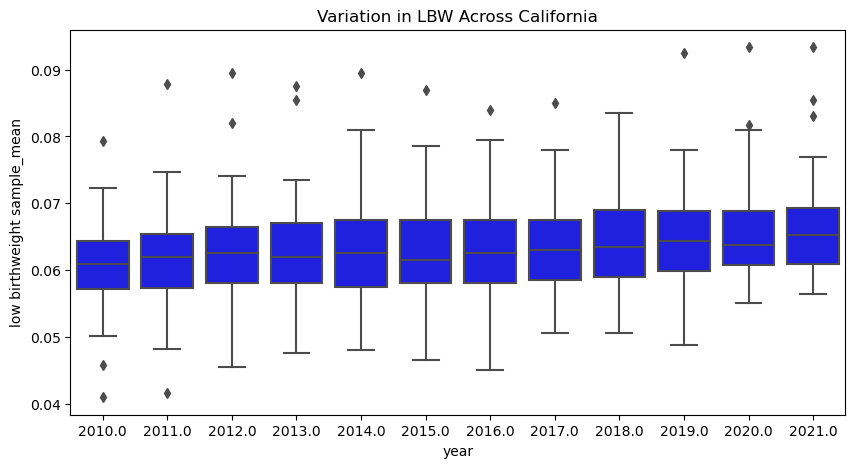

In [238]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Variation in LBW Across California')
sns.boxplot(x=analysis_data.year,y=analysis_data['low birthweight sample_mean'], color='blue')

Text(0.5, 1.0, 'Variation in LBW Across California')

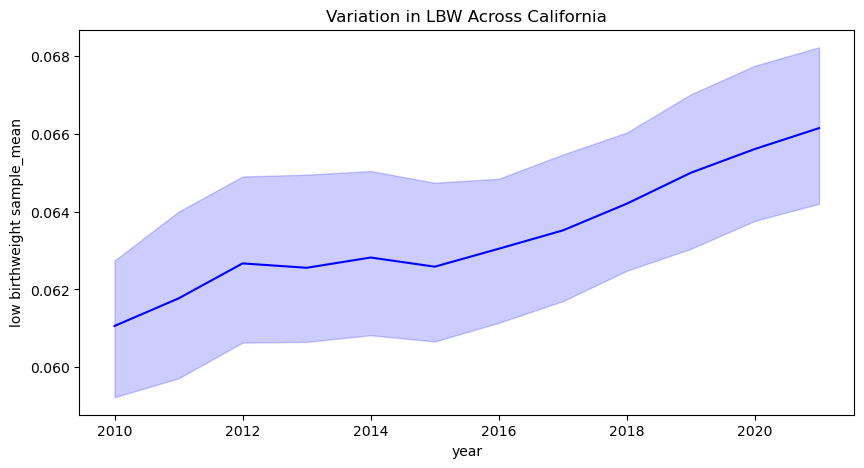

In [239]:
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(x=analysis_data.year,y=analysis_data['low birthweight sample_mean'], color='blue')
plt.title('Variation in LBW Across California')

<AxesSubplot: title={'center': 'Variation in Median AQI Scores Across California'}, xlabel='year', ylabel='median aqi'>

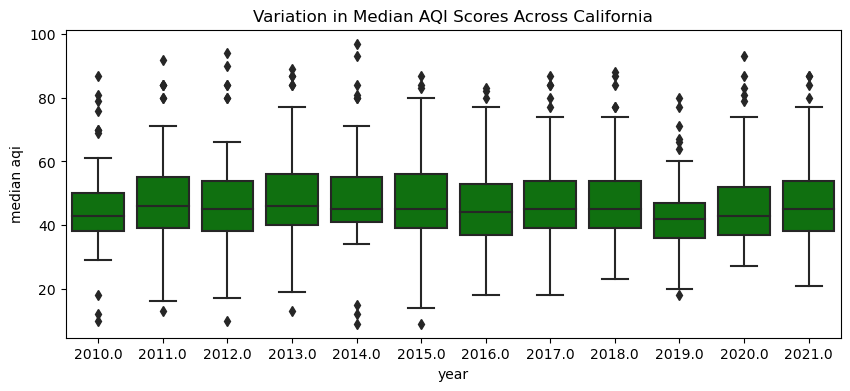

In [240]:
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('Variation in Median AQI Scores Across California')
sns.boxplot(x=analysis_data.year,y=analysis_data['median aqi'], color='green')


<AxesSubplot: title={'center': 'Variation in Max AQI Scores Across California'}, xlabel='year', ylabel='max aqi'>

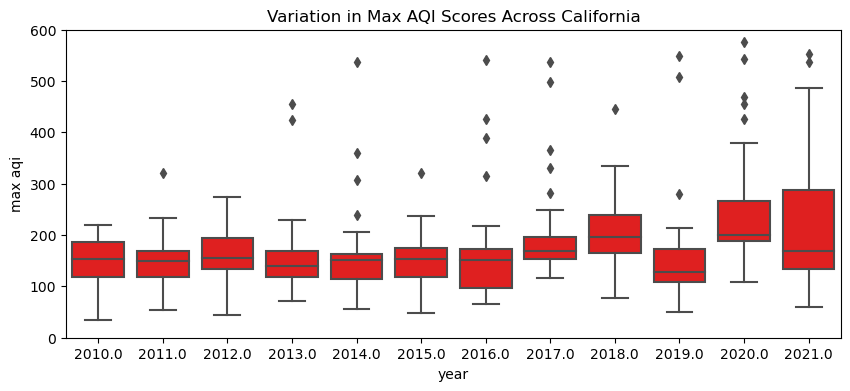

In [241]:
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('Variation in Max AQI Scores Across California')
ax1.set_ylim(0,600)
sns.boxplot(x=analysis_data.year,y=analysis_data['max aqi'], color='red')


### Regression Testing

In [242]:
independent_variables = list(cali_air_quality.columns)[3:]
dependent_variables = list(cali_data.columns)[2:]
context_variables = ['county','year']

In [243]:
X = analysis_data[independent_variables]
y = analysis_data['low birthweight sample_mean']

In [276]:
X.columns

Index(['good days', 'moderate days', 'unhealthy for sensitive groups days',
       'unhealthy days', 'very unhealthy days', 'hazardous days', 'max aqi',
       '90th percentile aqi', 'median aqi', 'days co', 'days no2',
       'days ozone', 'days pm2.5', 'days pm10'],
      dtype='object')

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [245]:
model.score(X_train,y_train)


0.31314235555717607

In [246]:
model.score(X_test,y_test)


0.3440850480243386

In [247]:
y_preds = model.predict(X_test)
sklearn.metrics.r2_score(y_test,y_preds)

0.3440850480243386

In [248]:
cross_val_score(model, X_train, y_train, cv=2)

array([0.25868157, 0.19269002])

#### Conducting a regression on just the 10 Worst Counties in California

In [249]:
worst_counties = analysis_data[['county','median aqi']].groupby('county').describe().sort_values(('median aqi','mean'),ascending=False).head(10)
county_focus = worst_counties.index.values
worst_counties_data = analysis_data.query('county in @county_focus')
worst_X = worst_counties_data[independent_variables]
worst_y = worst_counties_data['low birthweight sample_mean']

In [250]:
X_train, X_test, y_train, y_test = train_test_split(worst_X, worst_y, test_size=0.33, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [251]:
model.score(X_train,y_train)

0.5014970366844862

In [252]:
model.score(X_test,y_test)

0.40255152313544684

In [253]:
y_preds = model.predict(X_test)
sklearn.metrics.r2_score(y_test,y_preds)

0.40255152313544684

Text(0.5, 1.0, 'Coefficients of Multi-Linear Regression')

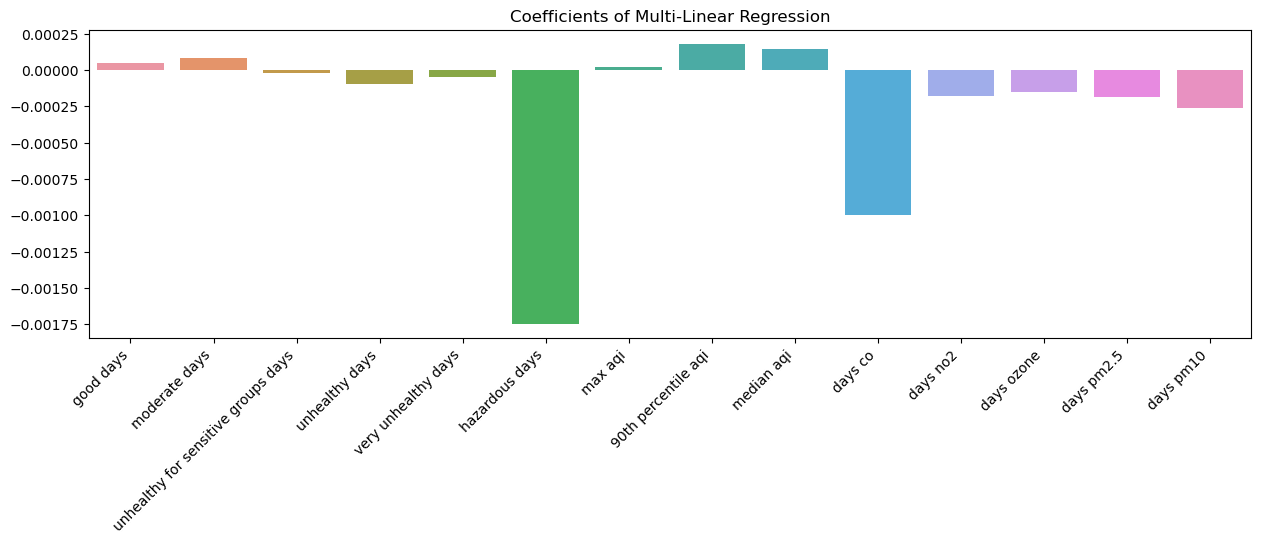

In [254]:
plt.figure(figsize=(15,4))

plt.xticks(rotation=45, ha="right")
sns.barplot(x=worst_X.columns,y=model.coef_)
plt.title('Coefficients of Multi-Linear Regression')

- As seen below, though there are instances across some counties where max AQI shows a very weak relationship with low birthrate variation, there are certainly more variables to consider looking forward

### Pollutants and LBW by County

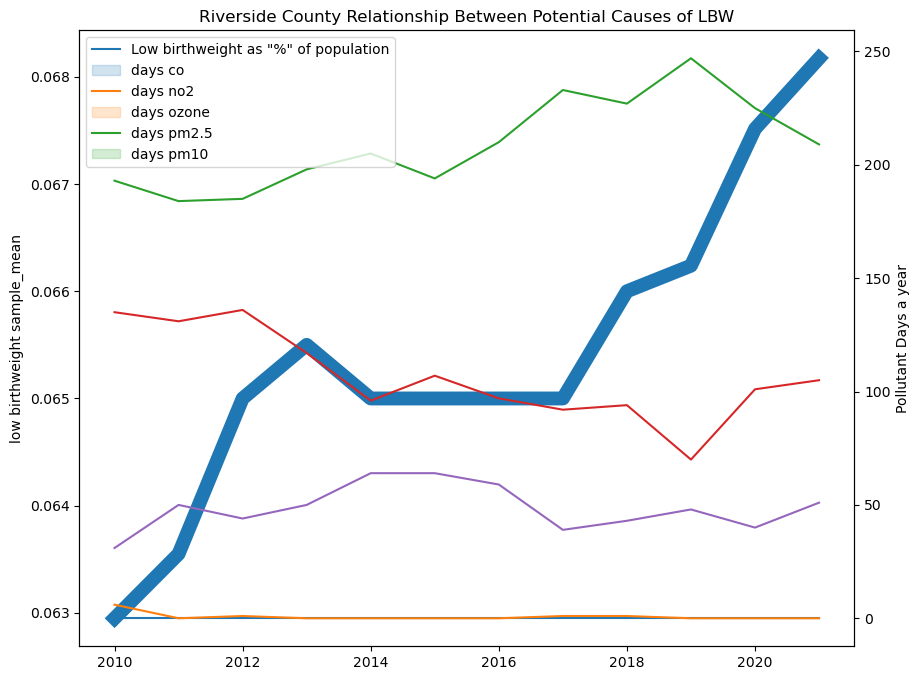

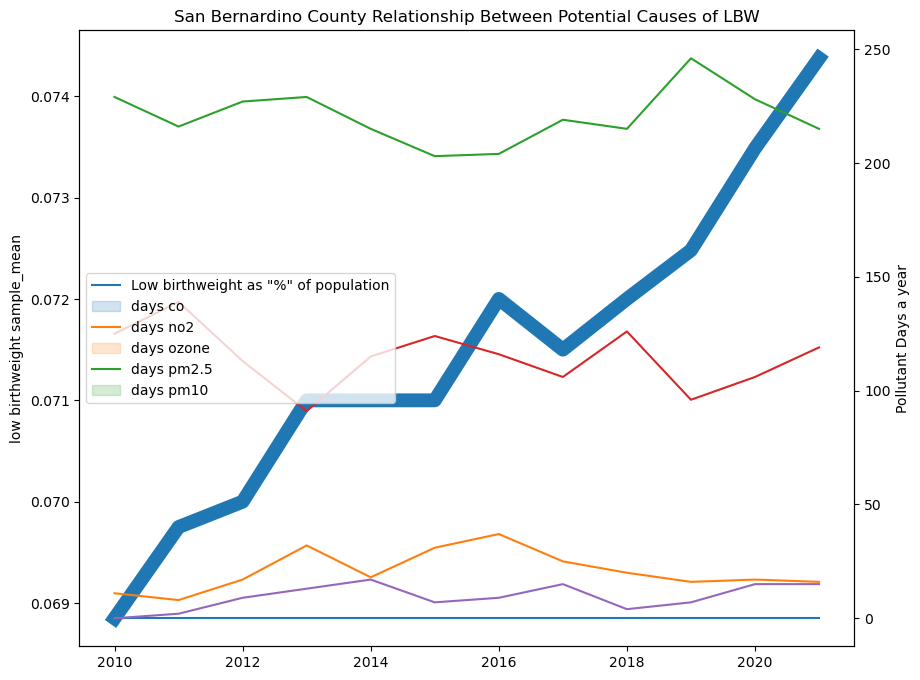

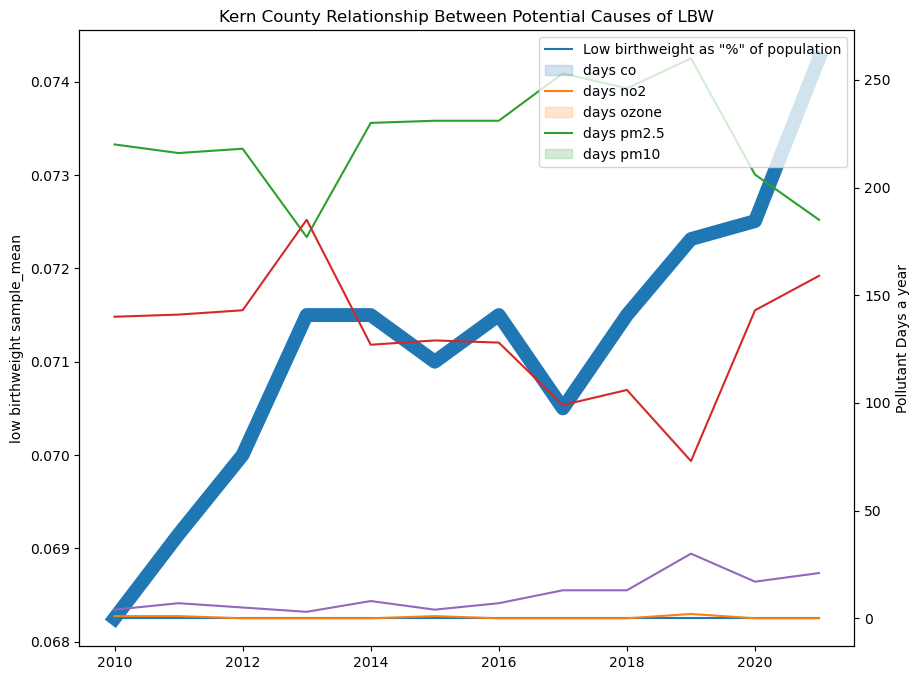

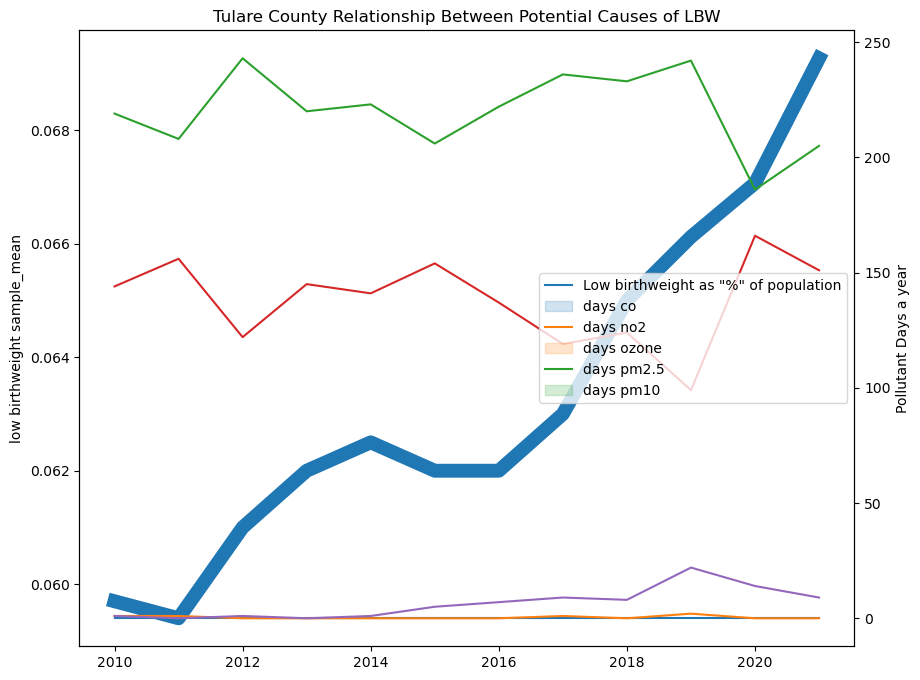

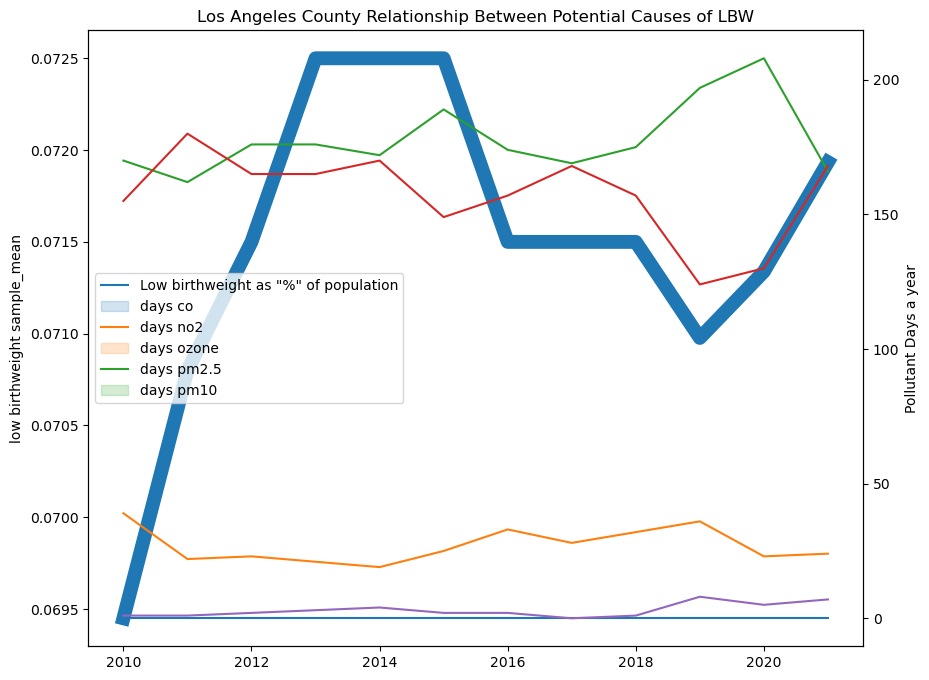

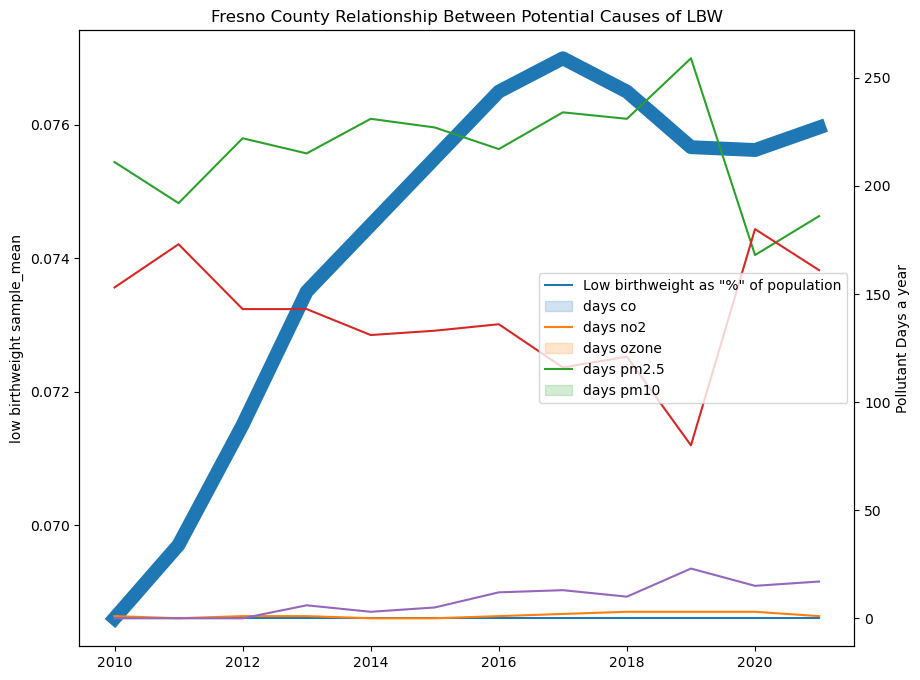

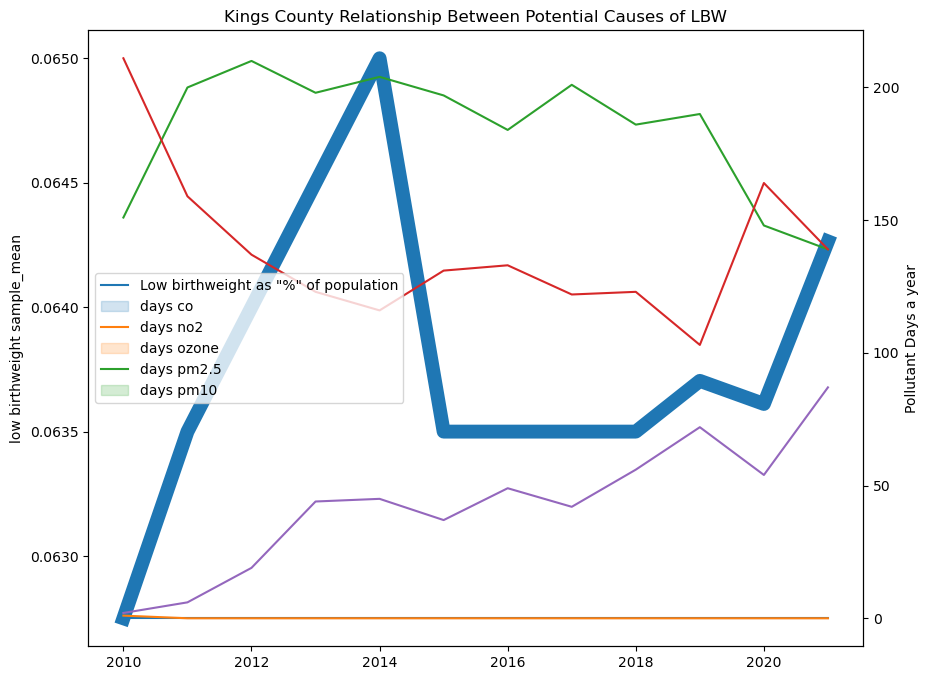

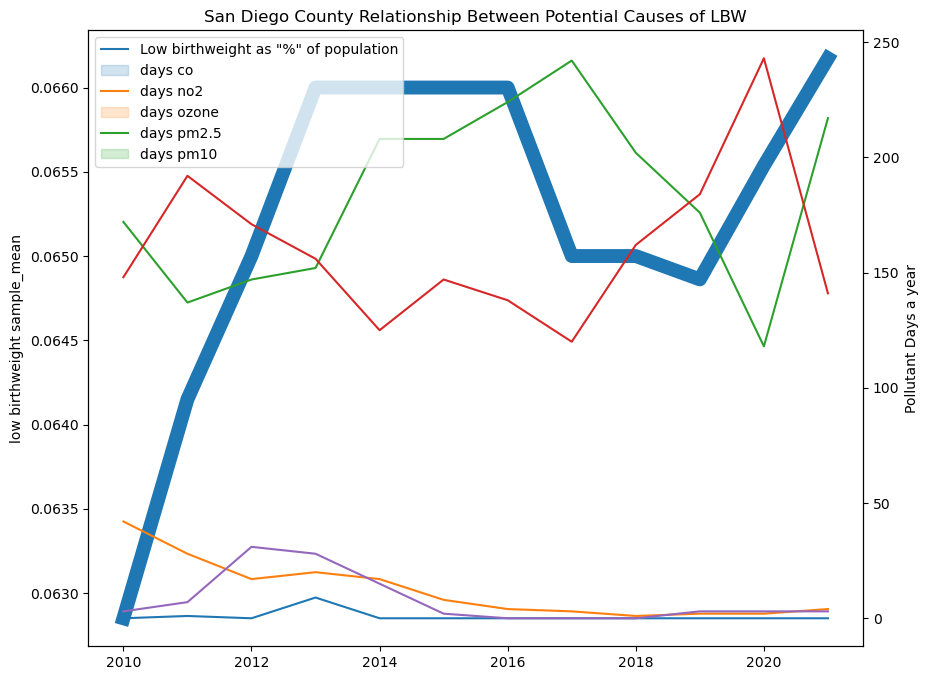

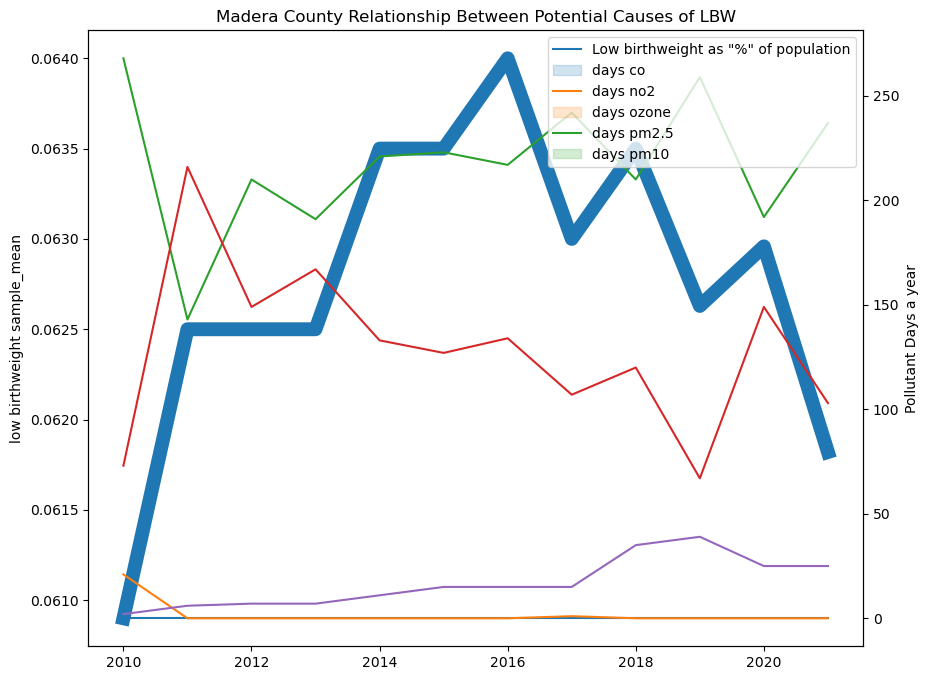

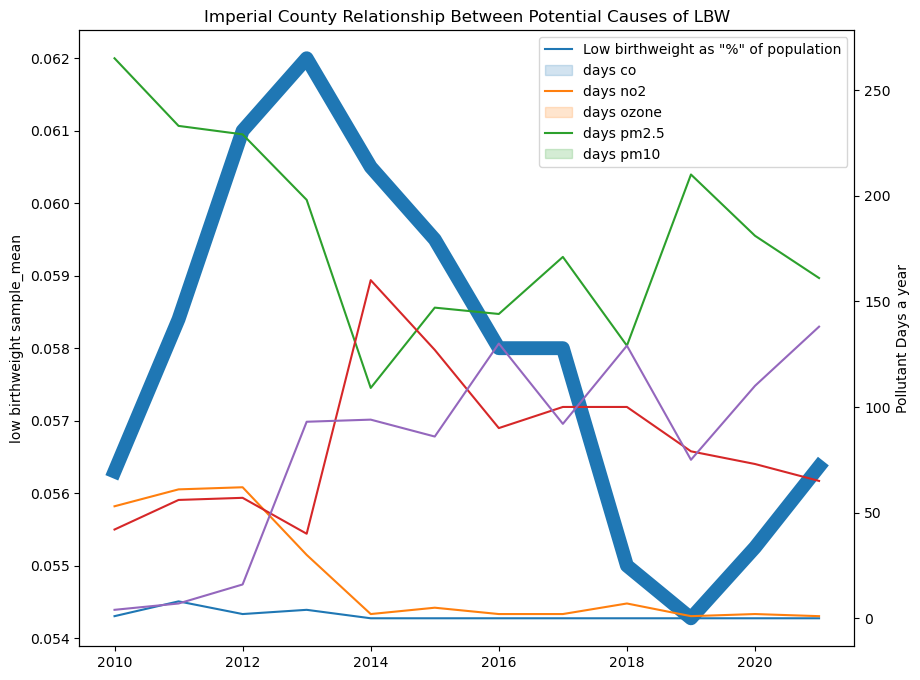

In [255]:
for county in county_focus: 
    lbw_sm = worst_counties_data.loc[worst_counties_data.county == county,'low birthweight sample_mean']
    i_v = worst_counties_data.loc[worst_counties_data.county == county, independent_variables] 
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Pollutant Days a year')

    plt.title('{} County Relationship Between Potential Causes of LBW'.format(county))
    sns.lineplot(x=worst_counties_data.year.unique(),y=lbw_sm,ax=ax1,linewidth=10)
    cnames = []
    for col in [x  for x in independent_variables if x[:4]=='days']:
        sns.lineplot(x=worst_counties_data.year.unique(),y=i_v[col],ax=ax2)
        #plt.set_label(col)
    plt.legend(['Low birthweight as "%" of population']+[x  for x in independent_variables if x[:4]=='days'])
    plt.show()

### AQI and LBW by County

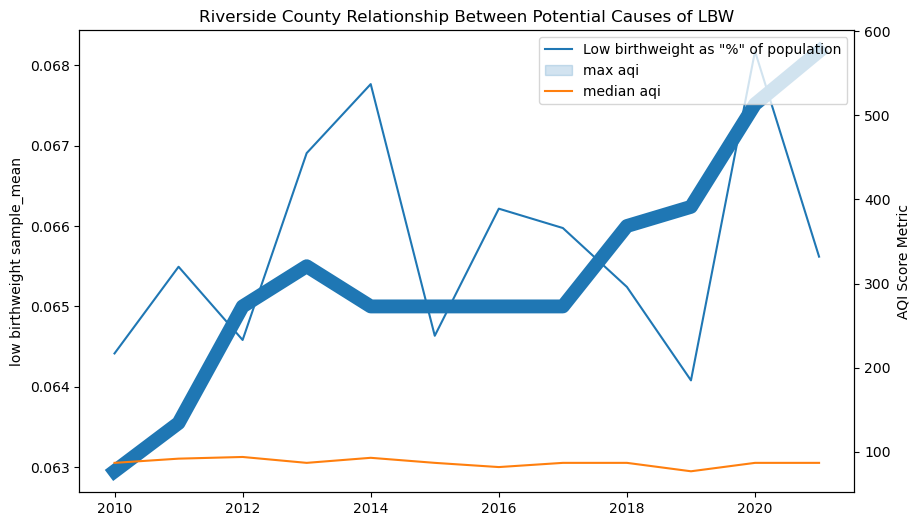

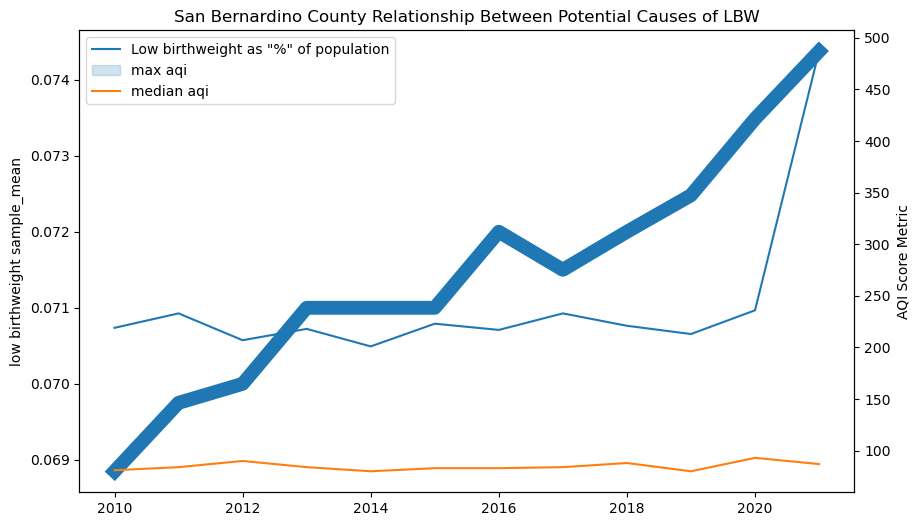

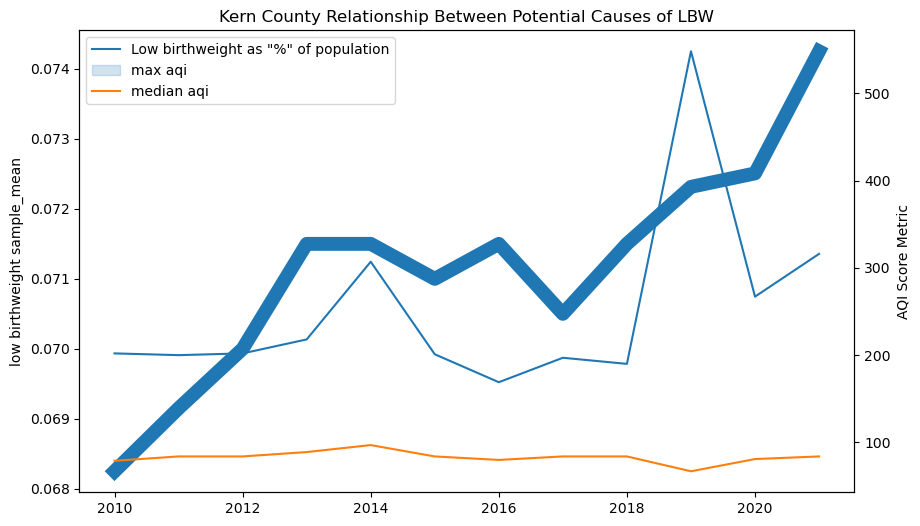

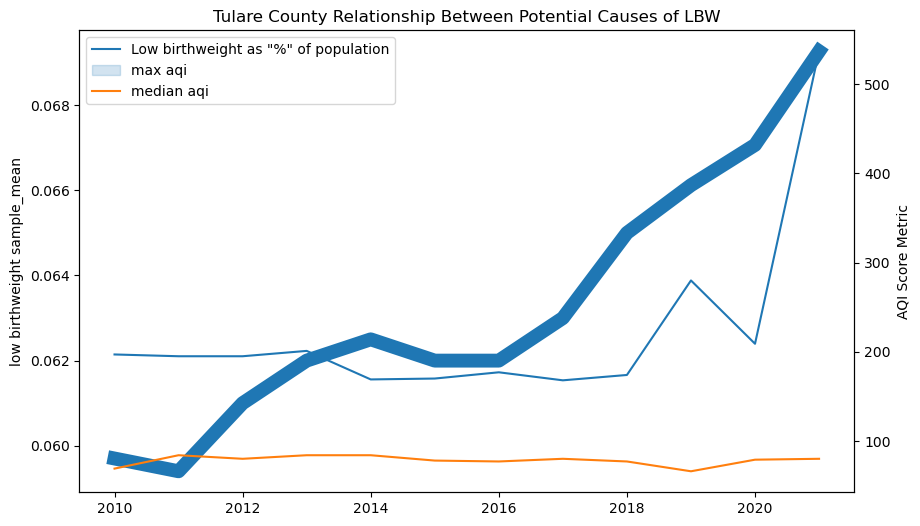

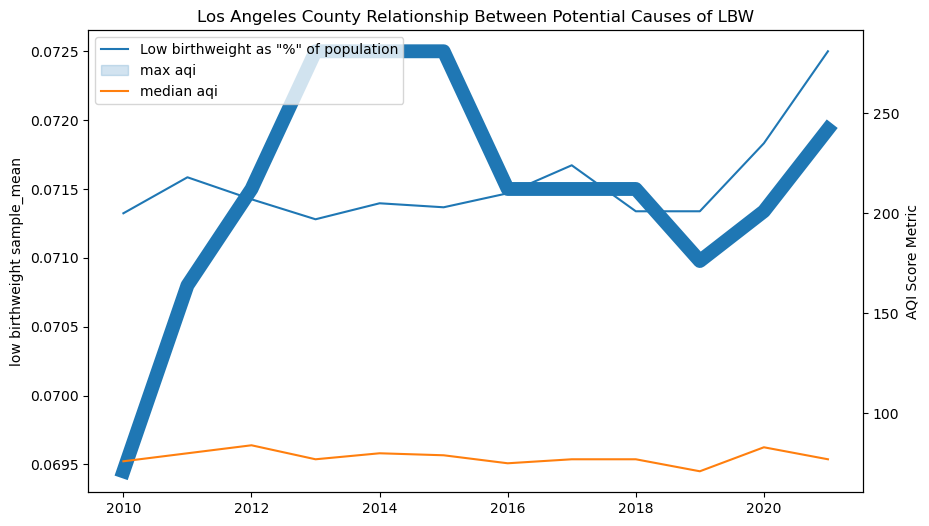

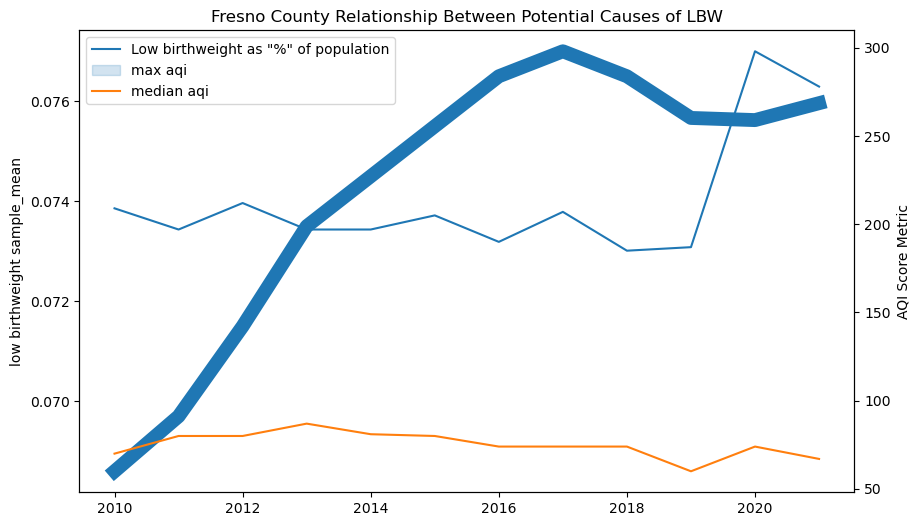

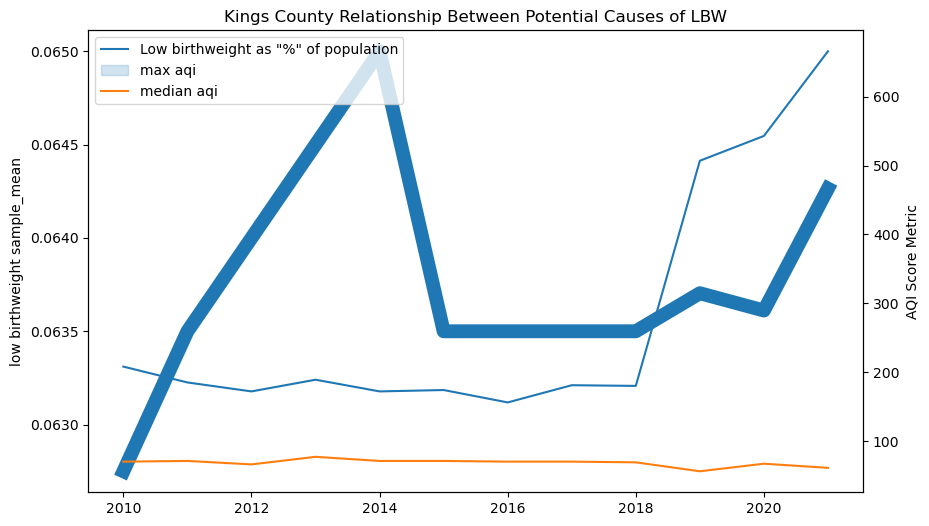

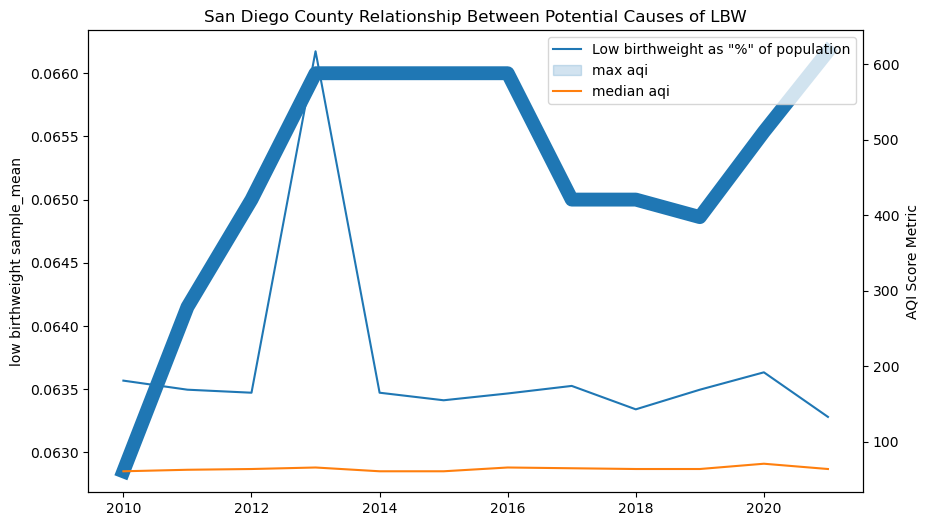

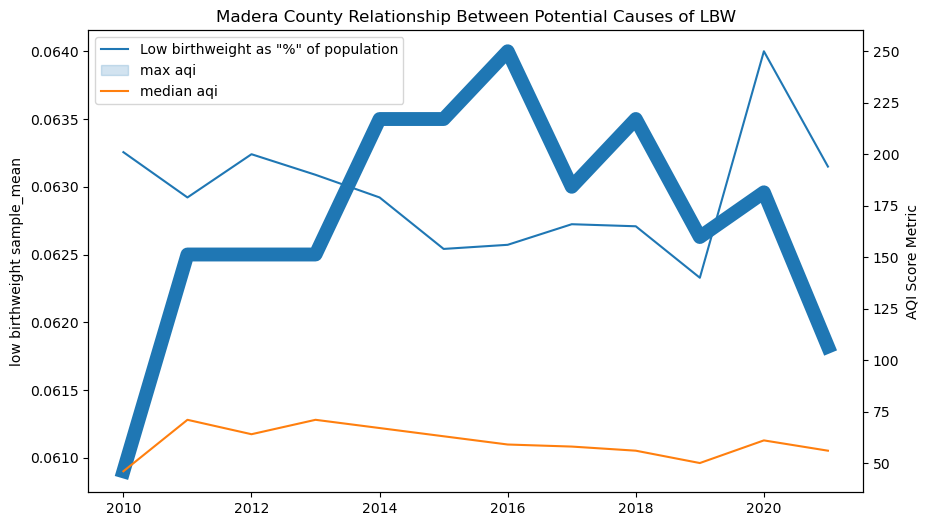

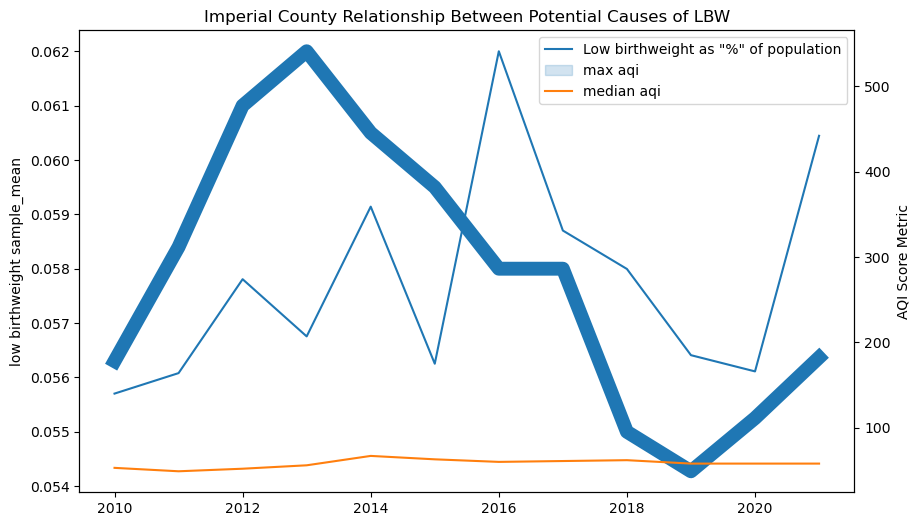

In [256]:
for county in county_focus: 
    lbw_sm = worst_counties_data.loc[worst_counties_data.county == county,'low birthweight sample_mean']
    i_v = worst_counties_data.loc[worst_counties_data.county == county, independent_variables] 
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax2.set_ylabel('AQI Score Metric')

    plt.title('{} County Relationship Between Potential Causes of LBW'.format(county))
    sns.lineplot(x=worst_counties_data.year.unique(),y=lbw_sm,ax=ax1,linewidth=10)
    cnames = []
    for col in ['max aqi','median aqi']:
        sns.lineplot(x=worst_counties_data.year.unique(),y=i_v[col],ax=ax2)
        #plt.set_label(col)
    plt.legend(['Low birthweight as "%" of population', 'max aqi', 'median aqi'])
    plt.show()

### Lasso Regression

- As a last effort to this dataset, we tried a lasso regression utilizing LassoCV, which optimizes the alpha value
- Though we were able to eliminate more than half of the features and improve the model, we ended with a 54% r2 score and ended our analysis on the LBW dataset

In [257]:
worst_counties = analysis_data[['county','median aqi']].groupby('county').describe().sort_values(('median aqi','mean'),ascending=False).head(10)
county_focus = worst_counties.index.values
worst_counties_data = analysis_data.query('county in @county_focus')
worst_X = worst_counties_data[independent_variables]
worst_y = worst_counties_data['low birthweight sample_mean']
X_train, X_test, y_train, y_test = train_test_split(worst_X, worst_y, test_size=0.2, random_state=42)
model = sklearn.linear_model.LassoCV()
model.fit(X_train,y_train)

c:\Users\Jack Koltermann\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6495844344325056e-07, tolerance: 2.187454243892952e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Jack Koltermann\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.761884261806533e-07, tolerance: 2.187454243892952e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Jack Koltermann\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.841589816658107e-07, tolerance: 2.187454243892952e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Jack Koltermann\anaconda3\lib\

LassoCV()

In [258]:
model.score(X_train,y_train)


0.4392443484786559

In [259]:
model.score(X_test,y_test)


0.5430814323902247

In [260]:
y_preds = model.predict(X_test)


In [261]:
sklearn.metrics.r2_score(y_test,y_preds)

0.5430814323902247

In [262]:
kept_x = [worst_X.columns[x] for x in range(len(model.coef_)) if (model.coef_[x] > .000001) | (model.coef_[x] < -.000001) ]
kept_y = [model.coef_[x] for x in range(len(model.coef_)) if (model.coef_[x] > .000001) | (model.coef_[x] < -.000001) ]

In [275]:
kept_x

['good days', 'max aqi', '90th percentile aqi', 'days ozone', 'days pm10']

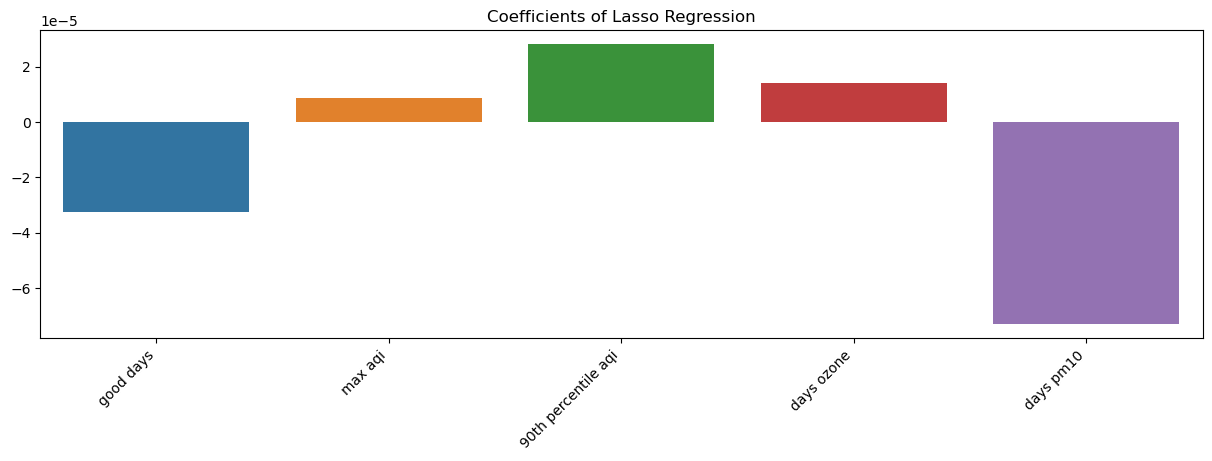

In [263]:
plt.figure(figsize=(15,4))

plt.xticks(rotation=45, ha="right")
sns.barplot(x=kept_x,y=kept_y)
plt.title('Coefficients of Lasso Regression')
plt.show()